# Intrusion Detection System Analysis, VAEs, and Prediction

#### Connor McManigal, Aaron Mui, Rishabh Verma, and Peyton Politewicz

## Imports and Data Preprocessing

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import colormaps
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from VAE1 import VAE1
from VAE2 import VAE2
from sklearn.decomposition import PCA
from bayes_opt import BayesianOptimization, UtilityFunction
from bayes_opt.logger import JSONLogger
from bayes_opt.event import Events
from bayes_opt.util import load_logs
from tqdm import tqdm
from sklearn import metrics
import torch.nn.functional as F
from IPython.display import clear_output

In [3]:
## list of indicies that correspond to the categorical features

cat_feature_idx=[i for i in range(43,56)]
cat_feature_idx.extend([17,18])

In [4]:
df = pd.read_csv('RT_IOT2022.csv')
x = df.drop(['Attack_type'], axis = 1)
y = df[['Attack_type']]

print("Data Shape with Aggregates\n")
print("Rows:", x.shape[0])
print("Features:", x.shape[1])

Data Shape with Aggregates

Rows: 209959
Features: 83


In [5]:
X = x.filter(regex='^((?!max|min|avg|std).)*$')

print("Data Shape without Aggregates\n")
print("Rows:", X.shape[0])
print("Features:", X.shape[1])
X.head()

Data Shape without Aggregates

Rows: 209959
Features: 47


,id.orig_p,id.resp_p,proto,service,flow_duration,fwd_pkts_tot,bwd_pkts_tot,fwd_data_pkts_tot,bwd_data_pkts_tot,fwd_pkts_per_sec,...,bwd_bulk_bytes,fwd_bulk_packets,bwd_bulk_packets,fwd_bulk_rate,bwd_bulk_rate,active.tot,idle.tot,fwd_init_window_size,bwd_init_window_size,fwd_last_window_size
0,31004,53,udp,dns,0.005875,1,1,1,1,170.209561,...,0.0,0.0,0.0,0.000000,0.000000,5.875111e+03,0.0,0,0,0
1,54222,443,tcp,-,7.807541,159,144,134,38,20.364926,...,15569.5,62.5,15.5,10096.717546,33346.967364,7.807541e+06,0.0,11890,3216,11890
2,48618,80,tcp,http,0.216894,7,7,1,2,32.273807,...,0.0,0.0,0.0,0.000000,0.000000,3.060679e+05,0.0,29200,29200,1065
3,8,0,icmp,-,0.014496,10,10,10,10,689.841286,...,0.0,0.0,0.0,0.000000,0.000000,1.449609e+04,0.0,0,0,0
4,54222,443,tcp,-,8.797776,158,176,133,45,17.959084,...,15570.5,124.0,19.0,10251.481385,32467.560574,8.797776e+06,0.0,11890,3220,11890


## Exploratory Data Analysis

In [6]:
# get counts of targets
y.value_counts()

Attack_type               
DOS_SYN_Hping                 94659
Alexa                         86842
Thing_Speak                    8108
ARP_poisioning                 7750
MQTT_Publish                   4146
NMAP_UDP_SCAN                  2590
NMAP_XMAS_TREE_SCAN            2010
NMAP_OS_DETECTION              2000
NMAP_TCP_scan                  1002
DDOS_Slowloris                  534
Wipro_bulb                      253
Metasploit_Brute_Force_SSH       37
NMAP_FIN_SCAN                    28
Name: count, dtype: int64

/var/folders/cz/l6psql0n645gg3s7z5vxfrqr0000gn/T/ipykernel_34682/961355872.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data = y, x = y['Attack_type'], order = y['Attack_type'].value_counts().index, palette = 'CMRmap')


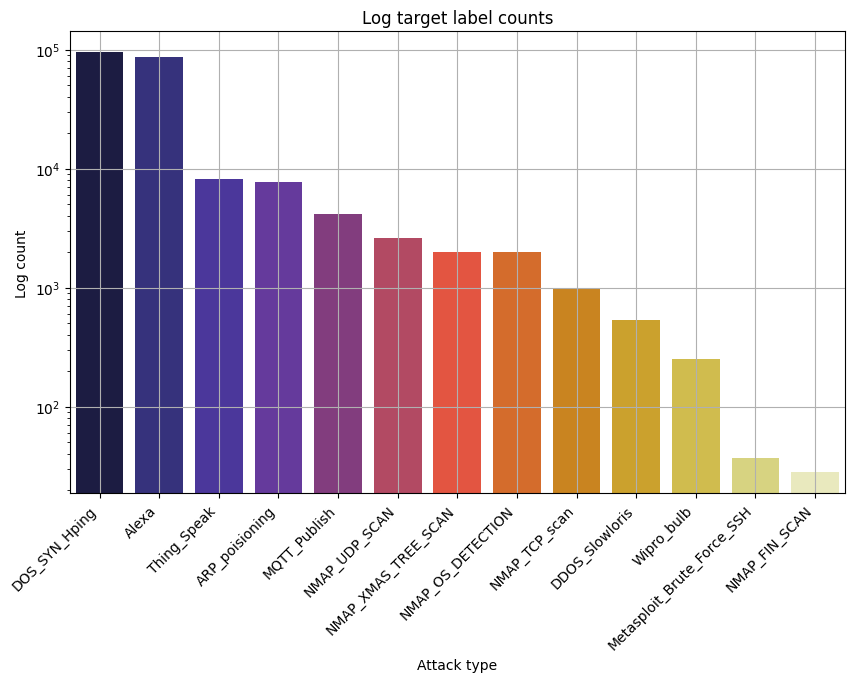

In [7]:
plt.figure(figsize = (10,6))
sns.countplot(data = y, x = y['Attack_type'], order = y['Attack_type'].value_counts().index, palette = 'CMRmap')
plt.yscale('log')
plt.ylabel('Log count')
plt.xlabel('Attack type')
plt.title('Log target label counts')
plt.xticks(rotation = 45, ha = 'right')
plt.grid()
plt.show()

In [8]:
# get counts of protocols
X['proto'].value_counts()

proto
tcp     190243
udp      17655
icmp      2061
Name: count, dtype: int64

In [9]:
# get counts of network services
X['service'].value_counts()

service
-         164484
ssl        20935
dns        14670
http        5471
mqtt        4132
ntp          128
dhcp          66
irc           43
ssh           28
radius         2
Name: count, dtype: int64

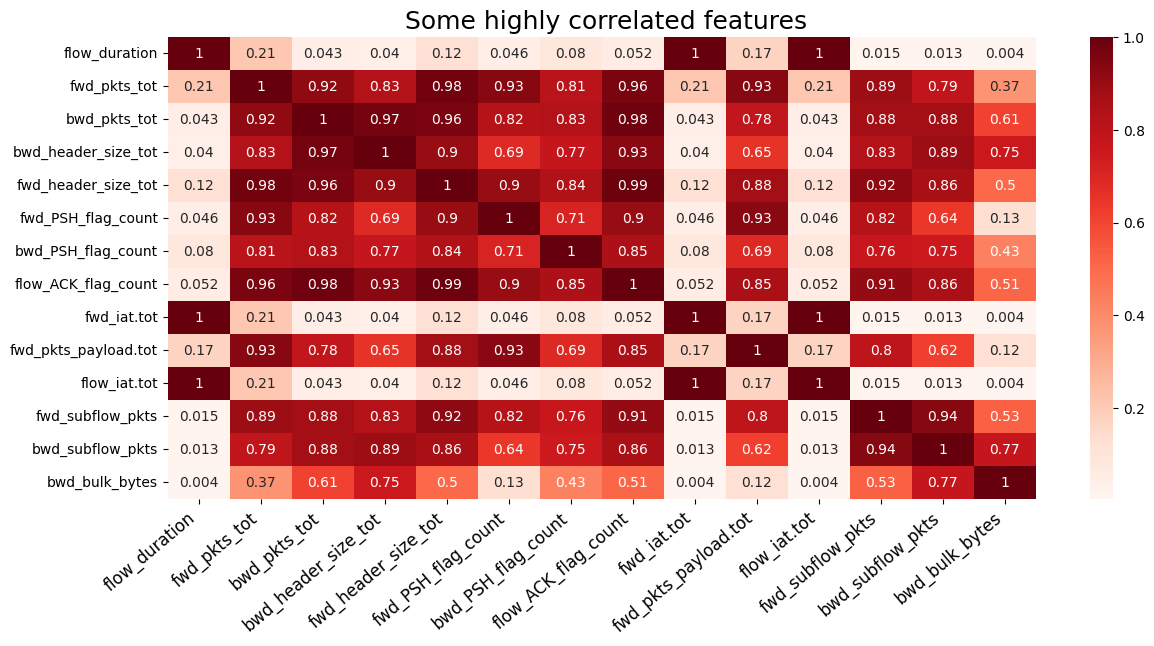

In [10]:
X_filter = X[['flow_duration', 'fwd_pkts_tot', 'bwd_pkts_tot', 'bwd_header_size_tot', 'fwd_header_size_tot', 'fwd_PSH_flag_count', 
                'bwd_PSH_flag_count', 'flow_ACK_flag_count', 'fwd_iat.tot', 'fwd_pkts_payload.tot', 'flow_iat.tot', 'fwd_subflow_pkts', 
                'bwd_subflow_pkts', 'bwd_bulk_bytes']]
X_corr = X_filter.corr()

plt.figure(figsize=(14,6))
sns.heatmap(X_corr, annot = True, cmap = 'Reds')
plt.title(' Some highly correlated features', fontsize = 18)
plt.xticks(rotation = 40, ha = 'right', fontsize = 12)
plt.show()

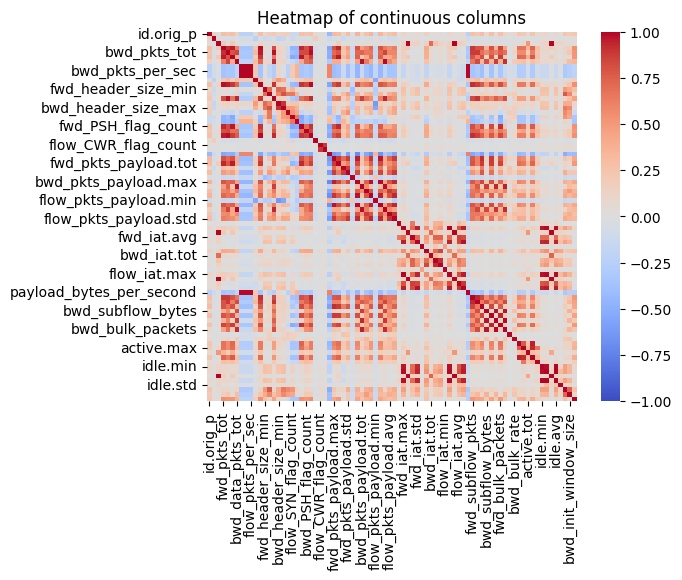

In [11]:
full_corr_matrix = x.drop(["proto", "service", "bwd_URG_flag_count"], axis=1).corr()
sns.heatmap(full_corr_matrix, cmap='coolwarm', cbar=True, vmin=-1, vmax=1, square=True)
plt.title("Heatmap of continuous columns")
plt.show()

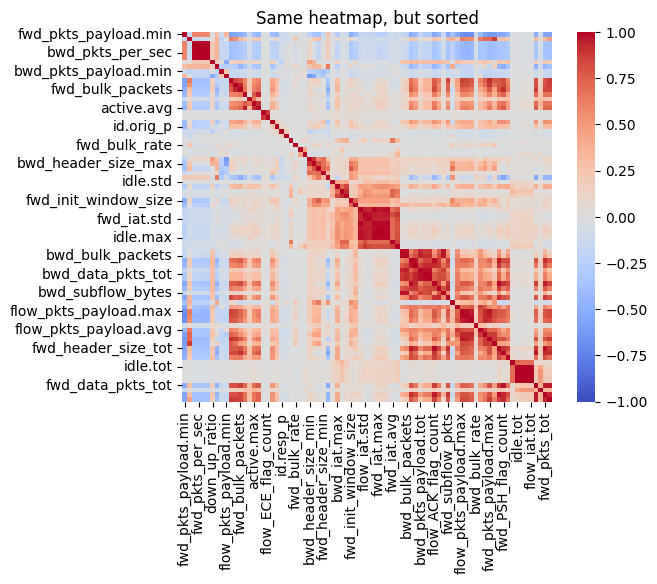

In [12]:
# Use agglomerative clustering on the heatmap
# Result is non-deterministic, so I saved a good value

#from scipy.cluster.hierarchy import linkage, leaves_list
#linkage_matrix = linkage(corr_matrix, method='complete')
#ordered_indices = leaves_list(linkage_matrix)

ordered_indices = np.array([26,29,56,7,8,9,10,19,31,36,59,61,63,67,71,68,70,24,25,79,0,1,23,41,65,46,51,15,16,13,12,18,76,47,49,50,77,78,72,55,45,75,42,52,73,44,54,62,64,4,14,33,6,38,22,58,60,57,17,34,37,32,35,66,39,40,27,30,11,20,21,48,74,43,2,53,5,69,3,28])
ordered_corr_matrix = full_corr_matrix.iloc[ordered_indices, ordered_indices]

sns.heatmap(ordered_corr_matrix, cmap='coolwarm', cbar=True, vmin=-1, vmax=1, square=True)
plt.title("Same heatmap, but sorted")
plt.show()

In [13]:
import plotly.graph_objs as go
import plotly.express as px

fig = px.imshow(np.round(np.abs(ordered_corr_matrix), 2),
                text_auto = True,
                labels = dict(color="Abs(Correlation)"),
                x = ordered_corr_matrix.columns,
                y = ordered_corr_matrix.columns,
                color_continuous_scale = "viridis",
                title="Interactive sorted heatmap")

fig.update_traces(hovertemplate="<b>%{x}</b> vs <b>%{y}</b><br>Abs(correlation): %{z:.2f}<extra></extra>")
fig.show()

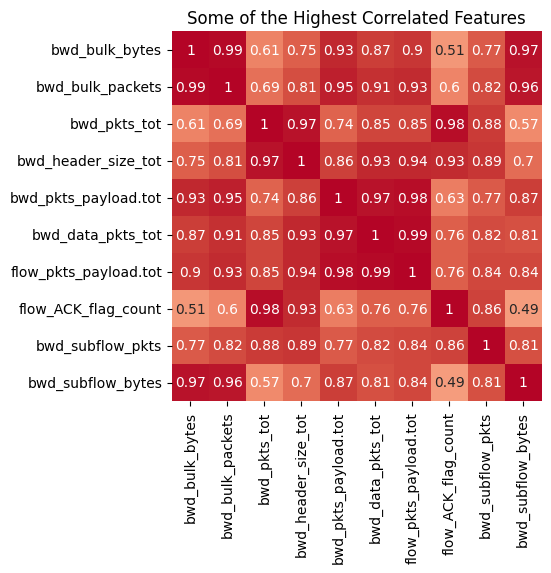

In [14]:
cols = range(47,57)
sub_corr_matrix = ordered_corr_matrix.iloc[cols, cols]
sns.heatmap(sub_corr_matrix, cmap='coolwarm', cbar=False, vmin=-1, vmax=1, annot=True, square=True)
plt.title('Some of the Highest Correlated Features')
plt.show()

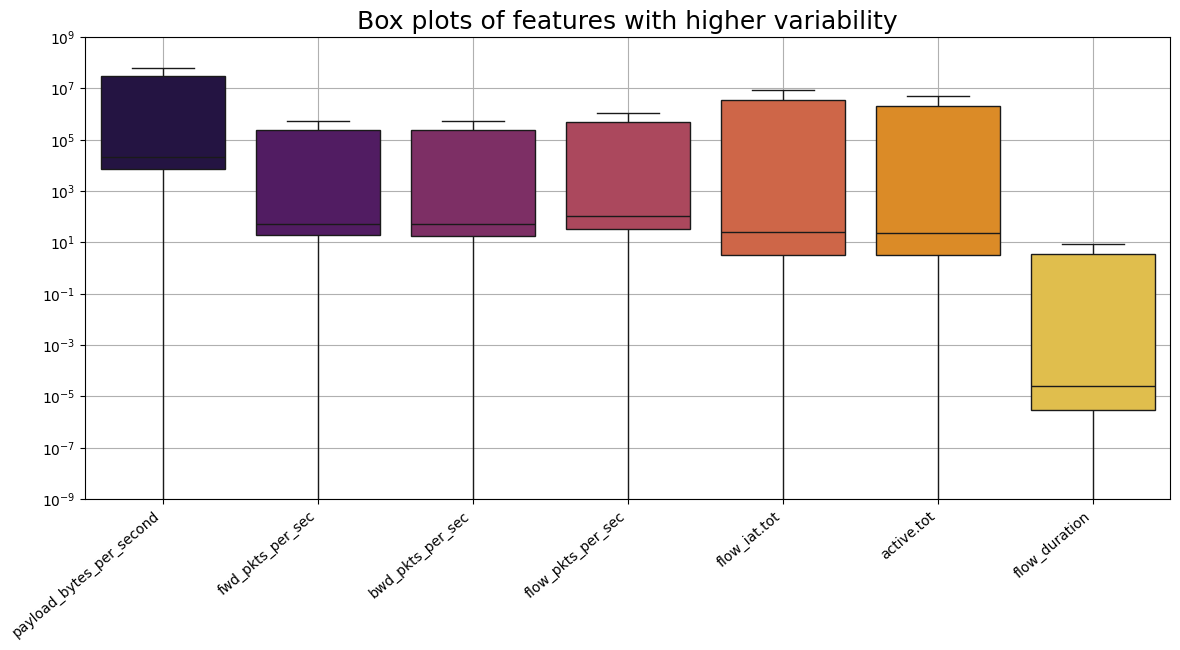

In [15]:
# visualize box plots of features with higher variability
X_higher_variability = X[['payload_bytes_per_second', 'fwd_pkts_per_sec', 'bwd_pkts_per_sec', 'flow_pkts_per_sec', 'flow_iat.tot', 'active.tot', 'flow_duration']]

plt.figure(figsize = (14,6))
sns.boxplot(data = X_higher_variability, showfliers = False, palette = 'inferno')
plt.yscale('log')
plt.ylim(10**-9, 10**9)
plt.xticks(rotation = 40, ha = 'right')
plt.title('Box plots of features with higher variability', fontsize  = 18)
plt.grid()
plt.show()

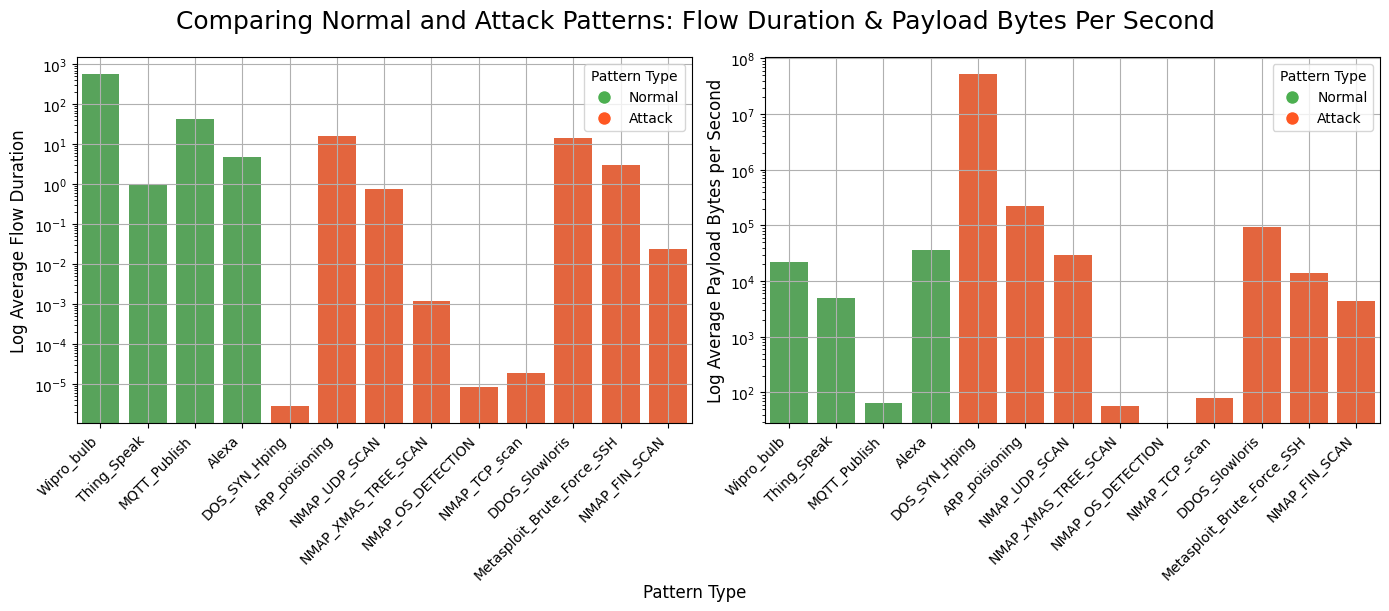

In [16]:
# average flow duration and payload bytes per second for normal patterns
full_data = pd.concat([X,y], axis = 1)

normal_types = [
    'Wipro_bulb',
    'Thing_Speak',
    'MQTT_Publish',
    'Alexa'
]

attack_types = [
    'DOS_SYN_Hping',
    'ARP_poisioning',
    'NMAP_UDP_SCAN',
    'NMAP_XMAS_TREE_SCAN',
    'NMAP_OS_DETECTION',
    'NMAP_TCP_scan',
    'DDOS_Slowloris',
    'Metasploit_Brute_Force_SSH',
    'NMAP_FIN_SCAN'
]
types = normal_types + attack_types

fig, axes = plt.subplots(1,2, figsize = (14,6))

for normal in normal_types:
    normal_patterns = full_data[full_data['Attack_type'] == normal]
    avg_flow_duration = normal_patterns['flow_duration'].mean()
    sns.barplot(x = [normal], y = [avg_flow_duration], ax = axes[0], color = '#4CAF50')

for attack in attack_types:
    attack_patterns = full_data[full_data['Attack_type'] == attack]
    avg_flow_duration = attack_patterns['flow_duration'].mean()
    sns.barplot(x = [attack], y = [avg_flow_duration], ax = axes[0], color = '#FF5722')

legend_labels = ['Normal', 'Attack']
colors = ['#4CAF50', '#FF5722']
legend_handles = [plt.Line2D([0], [0], marker = 'o', color = 'w', label = label, markerfacecolor = color, markersize = 10) for label, color in zip(legend_labels, colors)]

#axes[0].set_title('Log Average Flow Duration', fontsize = 13)
axes[0].set_ylabel('Log Average Flow Duration', fontsize = 12)
axes[0].set_yscale('log')
axes[0].grid()
axes[0].set_xticks(range(len(types)))
axes[0].set_xticklabels(types, rotation = 45, ha = 'right')
axes[0].legend(title = 'Pattern Type', handles = legend_handles, loc = 'upper right')


for normal in normal_types:
    normal_patterns = full_data[full_data['Attack_type'] == normal]
    avg_payload = normal_patterns['payload_bytes_per_second'].mean()
    sns.barplot(x = [normal], y = [avg_payload], ax = axes[1], color = '#4CAF50')

for attack in attack_types:
    attack_patterns = full_data[full_data['Attack_type'] == attack]
    avg_payload = attack_patterns['payload_bytes_per_second'].mean()
    sns.barplot(x = [attack], y = [avg_payload], ax = axes[1], color = '#FF5722')

#axes[1].set_title('Log Average Payload Bytes per Second', fontsize = 13)
axes[1].set_ylabel('Log Average Payload Bytes per Second', fontsize = '12')
axes[1].set_yscale('log')
axes[1].grid()
axes[1].set_xticks(range(len(types)))
axes[1].set_xticklabels(types, rotation = 45, ha = 'right')
axes[1].legend(title = 'Pattern Type', handles = legend_handles, loc = 'upper right')

plt.suptitle('Comparing Normal and Attack Patterns: Flow Duration & Payload Bytes Per Second', fontsize = 18)

fig.text(0.5, 0.0001, 'Pattern Type', ha = 'center', fontsize = 12)
plt.tight_layout()
plt.show()

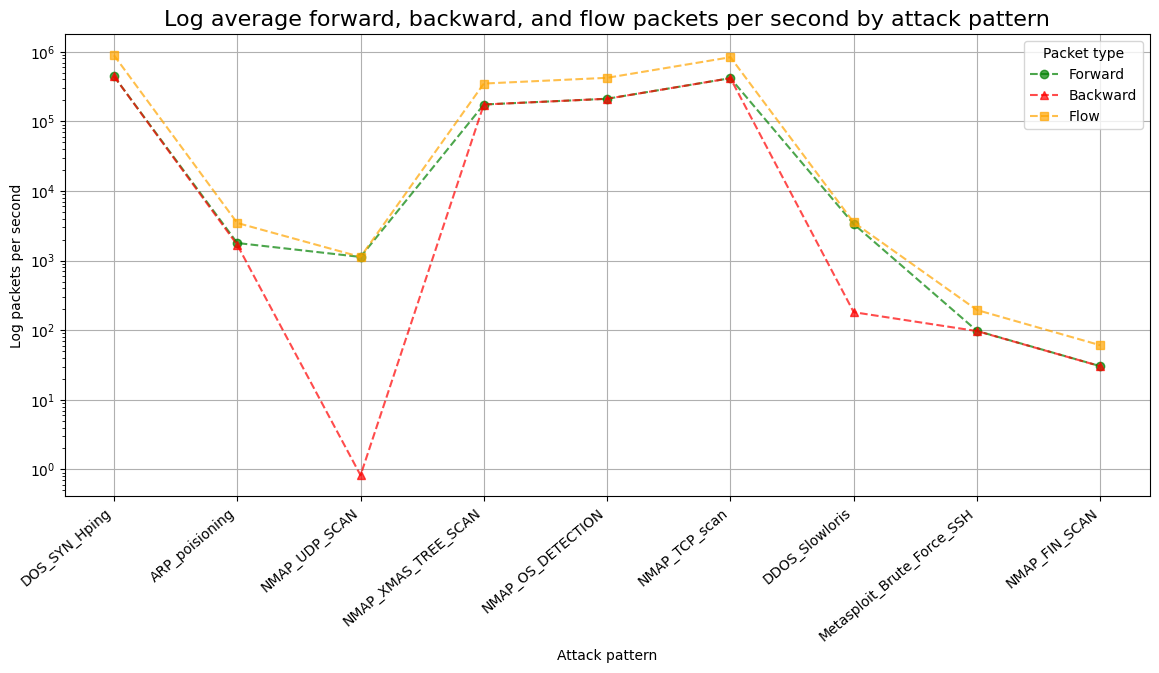

In [17]:
# forward, backward, and flow packets per second by Attack Pattern
fwd = []
bwd = []
flow = []

plt.figure(figsize = (14, 6))

for attack in attack_types:
    attack_patterns = full_data[full_data['Attack_type'] == attack]
    avg_fwd_pkts = attack_patterns['fwd_pkts_per_sec'].mean()
    fwd.append(avg_fwd_pkts)
    avg_bwd_pkts = attack_patterns['bwd_pkts_per_sec'].mean()
    bwd.append(avg_bwd_pkts)
    avg_flow_pkts = attack_patterns['flow_pkts_per_sec'].mean()
    flow.append(avg_flow_pkts)

plt.plot(attack_types, fwd, label = 'Forward',  linestyle = '--', marker = 'o', color = 'green', alpha = 0.7)
plt.plot(attack_types, bwd, label = 'Backward', linestyle = '--', marker = '^', color = 'red', alpha = 0.7)
plt.plot(attack_types, flow, label = 'Flow',  linestyle = '--', marker = 's', color = 'orange', alpha = 0.7)
plt.title('Log average forward, backward, and flow packets per second by attack pattern', fontsize = 16)
plt.xlabel('Attack pattern')
plt.ylabel('Log packets per second')
plt.xticks(rotation = 40, ha = 'right')
plt.legend(title = "Packet type")
plt.grid()
plt.yscale('log')
plt.show()

## Variational Autoencoder Training Preparation

In [18]:
# begin preprocessing
df = pd.read_csv('RT_IOT2022.csv')
df = df.filter(regex='^((?!max|min|avg|std).)*$') # drop aggregates
df = df.drop(columns = ['id.orig_p', 'id.resp_p']) # drop IDs

# one-hot encode categoricals and standardize numerics
cat_cols = ['proto', 'service']
quant_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

preprocessor = ColumnTransformer(
    transformers = [
        ('quant', MinMaxScaler(), quant_cols),
        ('cat', OneHotEncoder(), cat_cols)
    ], 
    remainder = 'passthrough')

df_processed = preprocessor.fit_transform(df)
column_names = quant_cols + preprocessor.named_transformers_['cat'].get_feature_names_out(cat_cols).tolist()
column_names += df.columns.drop(quant_cols + cat_cols).tolist()
df = pd.DataFrame(df_processed, columns = column_names)

print('Final preprocessed data shape:', df.shape)

Final preprocessed data shape: (209959, 57)


In [19]:
def binary_label_convert(data):
    normal_types = ['Wipro_bulb', 'Thing_Speak', 'MQTT_Publish', 'Alexa']
    data['Binary_label'] = data['Attack_type'].apply(lambda x: 0 if x in normal_types else 1)
    return data

df = binary_label_convert(df)

In [20]:
df['Binary_label'].value_counts()

Binary_label
1    110610
0     99349
Name: count, dtype: int64

In [21]:
# performing splits for train, cv, test
normal = df[df['Binary_label'] == 0]
attack = df[df['Binary_label'] == 1]

# normal data: 70% for training and 30% for testing/validation
train_data, temp_normal = train_test_split(normal, test_size = 0.3, random_state = 21, stratify = normal['Attack_type'])
# further split normal data: 15% for cv and 15% for test
validate_normal, test_normal = train_test_split(temp_normal, test_size = 0.5, random_state = 21)
# attack data: 50% for cv, 50% for test
validate_attack, test_attack = train_test_split(attack, test_size = 0.5, random_state = 21)

# combine
cv_data = pd.concat([validate_normal, validate_attack])
test_data = pd.concat([test_normal, test_attack])

# final split variables
X_train = train_data.drop(columns = ['Attack_type', 'Binary_label'])
y_train = train_data[['Binary_label']]
type_train = train_data["Attack_type"]

X_cv = cv_data.drop(columns = ['Attack_type', 'Binary_label'])
y_cv = cv_data[['Binary_label']]
type_cv = cv_data["Attack_type"]

X_test = test_data.drop(columns = ['Attack_type', 'Binary_label'])
y_test = test_data[['Binary_label']]
type_test = test_data["Attack_type"]

# Convert X and y to tensors.
# labels can all remain as series.
asTensor = lambda df: torch.tensor(df.astype('float32').values, dtype = torch.float32)
X_train, y_train, X_cv, y_cv, X_test, y_test = [asTensor(df) for df in [X_train, y_train, X_cv, y_cv, X_test, y_test]]

In [22]:
batch_size = 64
train_dataset = TensorDataset(X_train)
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)

In [212]:
# set up for visualizing ELBO loss in real time
from IPython.display import clear_output

def plot_loss(loss):
    epoch = len(loss)
    plt.plot(1+np.arange(epoch), loss, marker='o', color='red')
    plt.ylim(bottom=0)
    plt.title('ELBO Loss during training')
    plt.xlabel('Epoch')
    plt.ylabel('ELBO Loss')
    plt.grid()

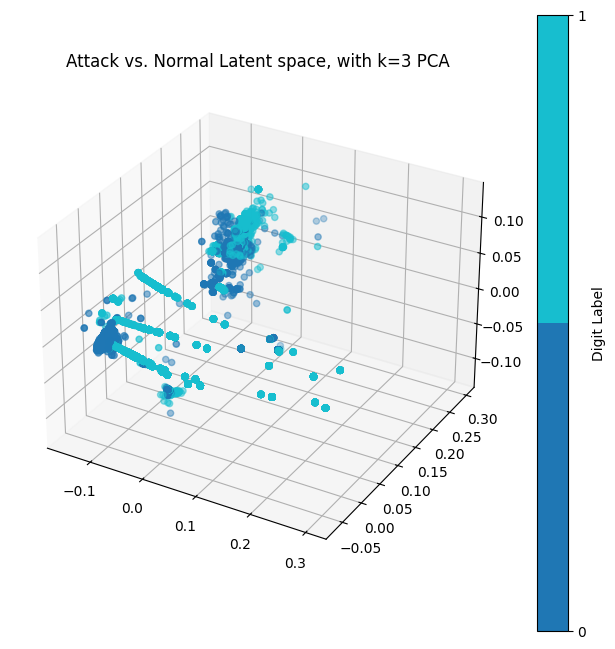

In [18]:
'''
Plot for normal vs attack latent representation
'''
# visualize latent dimensions with PCA
eval_data_labels = df['Binary_label']
eval_data_no_labels = df.drop(['Attack_type', 'Binary_label'], axis=1)
    
eval_data_loader = DataLoader(torch.from_numpy(eval_data_no_labels.astype('float32').values).float(), batch_size = eval_data_no_labels.shape[0], shuffle=False)

data = next(iter(eval_data_loader))

_, mu, _ = vae1(data)

latent_representations = mu.detach().numpy()

pca = PCA(n_components=3)
pca_result = pca.fit_transform(latent_representations)

# Plot the 3 highest dimensions in 3D
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

# Use the labels to color the points (optional)
label_encoder = LabelEncoder()
integer_labels = label_encoder.fit_transform(eval_data_labels)
#
unique_labels = np.unique(eval_data_labels)
num_unique_labels = len(unique_labels)
colors = plt.get_cmap('tab10', num_unique_labels)

scatter = ax.scatter(pca_result[:, 0], pca_result[:, 1], pca_result[:, 2], c=integer_labels, cmap=colors)

colorbar = fig.colorbar(scatter, ax=ax, label='Digit Label')
colorbar.set_ticks(np.arange(num_unique_labels))
colorbar.set_ticklabels(unique_labels)

plt.title("Attack vs. Normal Latent space, with k=3 PCA")
plt.show()

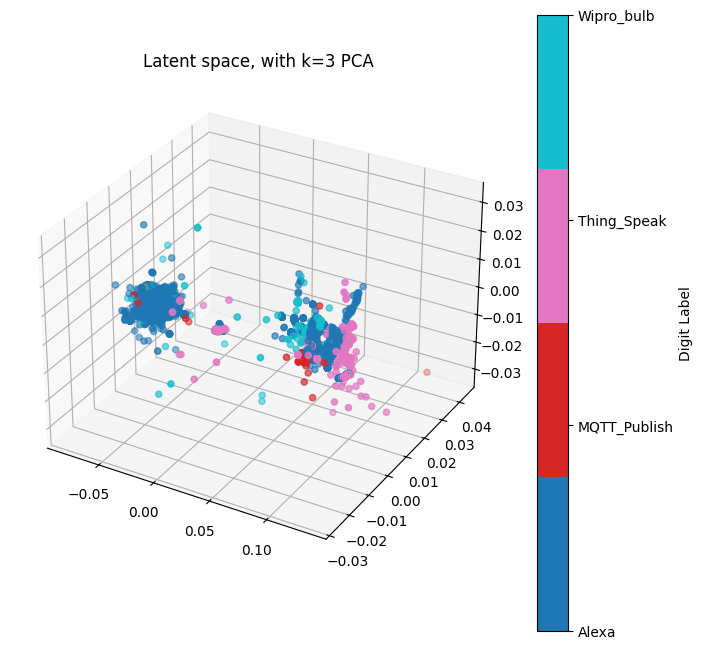

In [28]:
# visualize latent dimensions with PCA (probably intractable!)
eval_data_labels = train_data_labeled['Attack_type']
eval_data_no_labels = train_data_labeled.drop(['Attack_type', 'label'], axis=1)
    
eval_data_loader = DataLoader(torch.from_numpy(eval_data_no_labels.astype('float32').values).float(), batch_size = eval_data_no_labels.shape[0], shuffle=False)

data = next(iter(eval_data_loader))

_, mu, _ = vae(data)

latent_representations = mu.detach().numpy()


pca = PCA(n_components=3)
pca_result = pca.fit_transform(latent_representations)

# Plot the 3 highest dimensions in 3D
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

# Use the labels to color the points (optional)
label_encoder = LabelEncoder()
integer_labels = label_encoder.fit_transform(eval_data_labels)
#
unique_labels = np.unique(eval_data_labels)
num_unique_labels = len(unique_labels)
colors = plt.get_cmap('tab10', num_unique_labels)

scatter = ax.scatter(pca_result[:, 0], pca_result[:, 1], pca_result[:, 2], c=integer_labels, cmap=colors)

colorbar = fig.colorbar(scatter, ax=ax, label='Digit Label')
colorbar.set_ticks(np.arange(num_unique_labels))
colorbar.set_ticklabels(unique_labels)

plt.title("Latent space, with k=3 PCA")
plt.show()

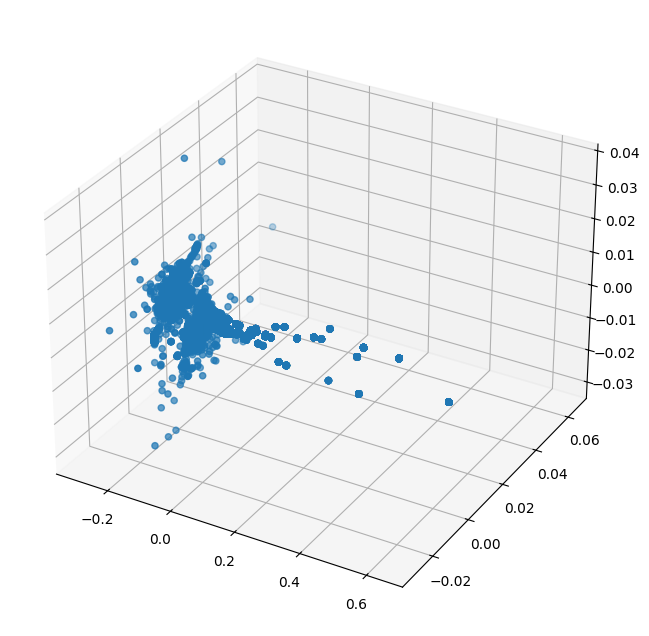

In [29]:
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

latent_representations = []
for data in train_loader:
    data = data[0]
    _, mu, _ = vae(data)
    latent_representations.append(mu.detach().numpy())
latent_representations = np.concatenate(latent_representations, axis=0)

pca = PCA(n_components=3)
pca_result = pca.fit_transform(latent_representations)

# Plot the 3 highest dimensions in 3D
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

# Use the labels to color the points (optional)

scatter = ax.scatter(pca_result[:, 0], pca_result[:, 1], pca_result[:, 2])


## Bayesian Optimization with cross-validation

We want to try a bunch of parameter options (z_min, h_min). 

As mentioned in "VAE Training on Normal Network Trace Patterns," we can also later take into account things like learning rate, batch normalization.

THESE NEXT ~SEVEN CHUNKS BEAR MY ENTIRE HOPES AND DREAMS

In [23]:
get_categorical_cols = lambda tensor: torch.all((tensor == 0) | (tensor == 1), dim=0).nonzero(as_tuple=True)[0]

assert get_categorical_cols(X_train).equal(get_categorical_cols(X_cv))
assert get_categorical_cols(X_train).equal(get_categorical_cols(X_test))

In [24]:
for attack_type in attack_types:
    pattern = '|'.join(normal_types + [attack_type])
    mask = type_cv.str.contains(pattern).values
    mask = torch.tensor(mask, dtype=torch.bool)
    testing_cv=X_cv[mask,:]

In [38]:
def train_model(modelClass, num_epochs=30, **kwargs):
    """
    This function initializes and trains a model on our training data with a given dictionary of hyperparameters,
    WITHOUT knowing anything about the model structure.
    
    model should be the model class, NOT an instance of the model
    
    kwargs should be the model hyperparameters that BayesOpt is working with
    """
    global X_train
    train_loader = DataLoader(TensorDataset(X_train), batch_size=64, shuffle=True)
    input_dim = X_train.shape[1]
    categorical_indices = get_categorical_cols(X_train)

    # using the hyperparameters and class passed in, init the model
    model = modelClass(input_dim=input_dim, **kwargs)
    optimizer = optim.Adam(model.parameters(), lr = 1e-5)

    losses = []
    for epoch in range(num_epochs):
        for data in train_loader:
            data = data[0]
            optimizer.zero_grad()
            reconstructed, mu, sigma = model(data)
            loss, _ = model.loss(reconstructed, data, mu, sigma, categorical_indices)
            loss.backward()
            optimizer.step()
        losses.append(loss.item())
        print(f"Loss: {loss.item():0.4f}")
    return model, losses


def evaluate(model, X_cv, y_cv, type_cv):
    """
    Given a trained model, perform the "One-vs-Rest" / "stratified holdout" / whatever-you-call-it style of cross-validation
    """
    global attack_types
    global normal_types

    AUC_metrics = {}
    for attack_type in attack_types:
        pattern = '|'.join(normal_types + [attack_type])
        mask = type_cv.str.contains(pattern).values
        mask = torch.tensor(mask, dtype=torch.bool)
        # Index X_cv and y_cv using the mask
        X_cv_ind=X_cv[mask,:]
        y_cv_ind=y_cv[mask,:]
        # Compute the model's reconstruction error for each row of X_cv
        model.eval()
        recon_errors_tensor = torch.empty(X_cv_ind.size(0))
        with torch.no_grad():
            for i in range(X_cv_ind.size(0)):
                x = X_cv_ind[i].unsqueeze(0)
                recon, mu, sigma = model(x)
                _, reconstruction_error = model.loss(recon, x, mu, sigma, cat_feature_indices=cat_feature_idx)
                recon_errors_tensor[i] = reconstruction_error
            # Reconstruction_error and y_cv should be vectors of the same size. Now use scikit-learn or whatever to compute an AUC.
            fpr, tpr, thresholds = metrics.roc_curve(y_cv_ind.numpy(), recon_errors_tensor.numpy(), pos_label=1)
            AUC=metrics.auc(fpr,tpr)

            AUC_metrics[attack_type] = AUC
    return AUC_metrics

# If everything goes as I intended, then for each of our 4 model classes, we can create a wrapper around this function passing in the modelClass, 
# and bayesOpt will try it out with lots of different kwargs.
def bayesOptBaseFunction(modelClass, **kwargs):
    global X_cv, y_cv, type_cv  # this isn't technically necessary, but it does improve code clarity

    for k in kwargs:
        kwargs[k] = int(kwargs[k])
    
    model, _ = train_model(modelClass, **kwargs)
    AUC_metrics = evaluate(model, X_cv, y_cv, type_cv)
    
    return np.median(list(AUC_metrics.values()))

In [39]:
from VAE1 import VAE1
from VAE2 import VAE2
from VAE1_mix import VAE3
from VAE2_mix import VAE4

z_dim_bounds = (5,60)
h_dim_bounds = (100,400)

VAE1_hyperparam_bounds = {
    "z_dim": z_dim_bounds,
    "h_dim": h_dim_bounds
}
VAE1_optim_func = lambda z_dim, h_dim: bayesOptBaseFunction(VAE1, z_dim=z_dim, h_dim=h_dim)


VAE2_hyperparam_bounds = {
    "z_dim": z_dim_bounds,
    "h_dim1": h_dim_bounds,
    "h_dim2": h_dim_bounds
}
VAE2_optim_func = lambda z_dim, h_dim1, h_dim2: bayesOptBaseFunction(VAE2, z_dim=z_dim, h_dim1=h_dim1, h_dim2=h_dim2)

VAE3_hyperparam_bounds = VAE2_hyperparam_bounds
VAE3_optim_func = lambda z_dim, h_dim1, h_dim2: bayesOptBaseFunction(VAE3, z_dim=z_dim, h_dim1=h_dim1, h_dim2=h_dim2)

VAE4_hyperparam_bounds = VAE1_hyperparam_bounds
VAE4_optim_func = lambda z_dim, h_dim: bayesOptBaseFunction(VAE4, z_dim=z_dim, h_dim=h_dim)

In [27]:
def runBayesOpt(optim_func, hyperparam_bounds, log_path, n_iter=10):
    bayesian_optimizer = BayesianOptimization(optim_func, hyperparam_bounds, verbose=0)

    # Read current log
    if os.path.exists(log_path):
        load_logs(bayesian_optimizer, logs=[log_path])
        print(f"Found {len(bayesian_optimizer.space)} points to start!")
        
    # Prepare to write to log.
    logger = JSONLogger(path=log_path, reset=False)
    bayesian_optimizer.subscribe(Events.OPTIMIZATION_STEP, logger)

    for i in range(n_iter):
        if len(bayesian_optimizer.space) >= 1:  # then print current results
            clear_output(wait=True)
            print(f"Iter {i}/{n_iter}")
            params = np.array(bayesian_optimizer.space.params).astype("int")
            vals = np.array(bayesian_optimizer.space.target)
            outcomes = np.hstack((params, np.reshape(vals, (-1,1))))
            outcomes = pd.DataFrame(outcomes, columns=bayesian_optimizer.space.keys + ['median AUC'])
            print(outcomes.sort_values("median AUC", ascending=False))

        if len(bayesian_optimizer.space) < 2:  # uninformed random search
            bayesian_optimizer.maximize(init_points=2, n_iter=0)
        else:
            bayesian_optimizer.maximize(init_points=0, n_iter=1)  # BayesOpt search

In [478]:
# Rishabh's chunk
runBayesOpt(VAE1_optim_func, VAE1_hyperparam_bounds, "VAE1_log.json", n_iter=200)

Iter 0/200
   h_dim  z_dim  median AUC
4  100.0   60.0    0.832338
1  387.0   44.0    0.828833
3  400.0    5.0    0.827049
0  318.0   40.0    0.826562
2  220.0   19.0    0.821765
Loss: 505.7693
Loss: 373.7213
Loss: 296.9944
Loss: 241.7735
Loss: 176.6775
Loss: 153.2803
Loss: 116.9161
Loss: 91.7327
Loss: 78.9391
Loss: 67.1035
Loss: 54.6248
Loss: 42.0105
Loss: 31.1393
Loss: 22.9940
Loss: 13.4688
Loss: 11.0836
Loss: 7.8208
Loss: 6.0074
Loss: 3.1898
Loss: 2.4820
Loss: 1.9567
Loss: 2.0317
Loss: 1.6336
Loss: 1.1314
Loss: 0.8372
Loss: 1.0995
Loss: 1.2179
Loss: 1.0894
Loss: 1.0009
Loss: 1.1663


KeyboardInterrupt: 

In [ ]:
# Connor's chunk
runBayesOpt(VAE2_optim_func, VAE2_hyperparam_bounds, "VAE2_log.json", n_iter=5)

In [40]:
# Aaron's chunk
runBayesOpt(VAE3_optim_func, VAE3_hyperparam_bounds, "VAE3_log.json", n_iter=50)

Iter 1/50
   h_dim1  h_dim2  z_dim  median AUC
0   248.0   251.0   26.0    0.729610
1   236.0   105.0   10.0    0.724319
Loss: 221.7025
Loss: 87.8279
Loss: 38.1175
Loss: 20.3996
Loss: 8.9897
Loss: 4.0465
Loss: 2.8448
Loss: 2.5039
Loss: 2.4441
Loss: 2.5810
Loss: 2.0365
Loss: 3.1245
Loss: 2.0954
Loss: 2.2205
Loss: 2.2506
Loss: 2.4465
Loss: 2.3257
Loss: 1.9699
Loss: 2.7260
Loss: 2.0339
Loss: 2.2020
Loss: 2.3846
Loss: 2.7376
Loss: 2.4354


In [ ]:
# Peyton's chunk
runBayesOpt(VAE4_optim_func, VAE4_hyperparam_bounds, "VAE4_log.json", n_iter=5)

In [347]:
# TODO REMOVE
# This chunk is for illustrative purposes, just to verify the kwargs work as intended

# This isn't as perfect as I'd hoped yet. It'd be nice if the modelClasses accept named arguments like z_dim, h_dim,
#    and then the sample_baseFunction would unpack the kwargs for the modelClasses, but I don't have time to figure that out rn, sowwy :3
def sample_model_A(input_dim, **kwargs):
    print(f"This would initialize model A with input_dim={input_dim}, {kwargs}") 

def sample_model_B(input_dim, **kwargs):
    print(f"This would initialize model B with input_dim={input_dim}, {kwargs}") 

def sample_baseFunction(modelClass, **kwargs):
    modelClass(input_dim=None, **kwargs)

sample_objective_A = lambda h_dim_1, h_dim_2, z_dim: sample_baseFunction(sample_model_A, kwargs={"h_dim_1":h_dim_1, "h_dim_2": h_dim_2, "z_dim":z_dim})
sample_objective_A(389, 435, 2)

sample_objective_B = lambda h_dim, z_dim: sample_baseFunction(sample_model_B, kwargs={"h_dim":h_dim, "z_dim":z_dim})
sample_objective_B(202, 76)

This would initialize model A with input_dim=None, {'kwargs': {'h_dim_1': 389, 'h_dim_2': 435, 'z_dim': 2}}
This would initialize model B with input_dim=None, {'kwargs': {'h_dim': 202, 'z_dim': 76}}


## VAE Testing Analysis